## PyTorch exercises

### Tensors

1. Make a tensor of size (2, 17)
2. Make a torch.FloatTensor of size (3, 1)
3. Make a torch.LongTensor of size (5, 2, 1)
  - fill the entire tensor with 7s
4. Make a torch.ByteTensor of size (5,)
  - fill the middle 3 indices with ones such that it records [0, 1, 1, 1, 0]
5. Perform a matrix multiplication of two tensors of size (2, 4) and (4, 2). Then do it in-place.
6. Do element-wise multiplication of two randomly filled $(n_1,n_2,n_3)$ tensors. Then store the result in an Numpy array.

### Forward-prop/backward-prop
1. Create a Tensor that `requires_grad` of size (5, 5).
2. Sum the values in the Tensor.
3. Multiply the tensor by 2 and assign the result to a new python variable (i.e. `x = result`)
4. Sum the variable's elements and assign to a new python variable
5. Print the gradients of all the variables
6. Now perform a backward pass on the last variable (NOTE: for each new python variable that you define, call `.retain_grad()`)
7. Print all gradients again

### Deep-forward NNs
1. Use dl_lab2. In Exercise 12 there, you had to build an $L$-layer neural network with the following structure: *[LINEAR -> RELU]$\times$(L-1) -> LINEAR -> SIGMOID*. Reimplement the manual code in PyTorch.
2. Compare test accuracy using different optimizers: SGD, Adam, Momentum.

## Implementing a deep convolutional neural network using PyTorch

### The multilayer CNN architecture

In [1]:
from IPython.display import Image
%matplotlib inline
Image(filename='figures/14_12.png', width=800)

FileNotFoundError: [Errno 2] No such file or directory: 'figures/14_12.png'

### Loading and preprocessing the data

In [3]:
import torch
import numpy as np
import torchvision 
from torchvision import transforms 
image_path = './'
transform = transforms.Compose([transforms.ToTensor()])

mnist_dataset = torchvision.datasets.MNIST(root=image_path, 
                                           train=True, 
                                           transform=transform, 
                                           download=True)

from torch.utils.data import Subset
mnist_valid_dataset = Subset(mnist_dataset, torch.arange(10000)) 
mnist_train_dataset = Subset(mnist_dataset, torch.arange(10000, len(mnist_dataset)))
mnist_test_dataset = torchvision.datasets.MNIST(root=image_path, 
                                           train=False, 
                                           transform=transform, 
                                           download=True)

Using downloaded and verified file: ./MNIST/raw/train-images-idx3-ubyte.gz
Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Using downloaded and verified file: ./MNIST/raw/train-labels-idx1-ubyte.gz
Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Using downloaded and verified file: ./MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 13844861.02it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [4]:
from torch.utils.data import DataLoader


batch_size = 64
torch.manual_seed(1)
train_dl = DataLoader(mnist_train_dataset, batch_size, shuffle=True)
valid_dl = DataLoader(mnist_valid_dataset, batch_size, shuffle=False)

### Implementing a CNN using the torch.nn module

#### Configuring CNN layers in PyTorch

 * **Conv2d:** `torch.nn.Conv2d`
   * `out_channels`
   * `kernel_size`
   * `stride`
   * `padding`
   
   
 * **MaxPool2d:** `torch.nn.MaxPool2d`
   * `kernel_size`
   * `stride`
   * `padding`
   
   
 * **Dropout** `torch.nn.Dropout`
   * `p`

### Constructing a CNN in PyTorch

In [5]:
import torch.nn as nn
model = nn.Sequential()
model.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2))
model.add_module('relu1', nn.ReLU())        
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))   
model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2))
model.add_module('relu2', nn.ReLU())        
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))      

x = torch.ones((4, 1, 28, 28))
model(x).shape

torch.Size([4, 64, 7, 7])

In [6]:
model.add_module('flatten', nn.Flatten()) 

x = torch.ones((4, 1, 28, 28))
model(x).shape

torch.Size([4, 3136])

In [7]:
model.add_module('fc1', nn.Linear(3136, 1024)) 
model.add_module('relu3', nn.ReLU()) 
model.add_module('dropout', nn.Dropout(p=0.5)) 

model.add_module('fc2', nn.Linear(1024, 10)) 

In [9]:
device = torch.device("cpu")
#device = torch.device("cpu")

model = model.to(device) 

In [11]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device) 
            y_batch = y_batch.to(device) 
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)
        
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device) 
                y_batch = y_batch.to(device) 
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0) 
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float() 
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
        
        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

torch.manual_seed(1)
num_epochs = 20
hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.9786 val_accuracy: 0.9829
Epoch 2 accuracy: 0.9866 val_accuracy: 0.9881
Epoch 3 accuracy: 0.9905 val_accuracy: 0.9889
Epoch 4 accuracy: 0.9923 val_accuracy: 0.9872
Epoch 5 accuracy: 0.9944 val_accuracy: 0.9885
Epoch 6 accuracy: 0.9949 val_accuracy: 0.9897
Epoch 7 accuracy: 0.9965 val_accuracy: 0.9863
Epoch 8 accuracy: 0.9961 val_accuracy: 0.9900
Epoch 9 accuracy: 0.9967 val_accuracy: 0.9881
Epoch 10 accuracy: 0.9973 val_accuracy: 0.9867
Epoch 11 accuracy: 0.9972 val_accuracy: 0.9899
Epoch 12 accuracy: 0.9967 val_accuracy: 0.9894
Epoch 13 accuracy: 0.9978 val_accuracy: 0.9899
Epoch 14 accuracy: 0.9980 val_accuracy: 0.9878
Epoch 15 accuracy: 0.9978 val_accuracy: 0.9903
Epoch 16 accuracy: 0.9981 val_accuracy: 0.9894
Epoch 17 accuracy: 0.9979 val_accuracy: 0.9893
Epoch 18 accuracy: 0.9984 val_accuracy: 0.9911
Epoch 19 accuracy: 0.9986 val_accuracy: 0.9909
Epoch 20 accuracy: 0.9983 val_accuracy: 0.9895


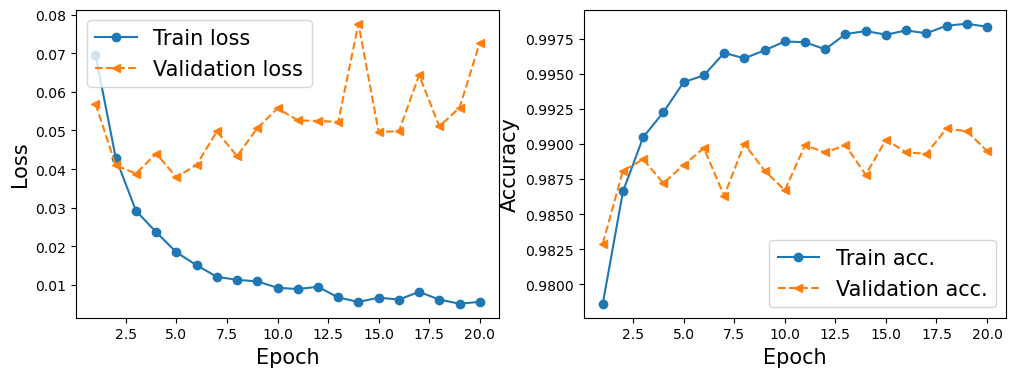

In [12]:
import matplotlib.pyplot as plt


x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

#plt.savefig('figures/14_13.png')
plt.show()

In [ ]:
model_cpu = model.cpu()
pred = model(mnist_test_dataset.data.unsqueeze(1) / 255.)
is_correct = (torch.argmax(pred, dim=1) == mnist_test_dataset.targets).float()
print(f'Test accuracy: {is_correct.mean():.4f}') 

In [ ]:
fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    img = mnist_test_dataset[i][0][0, :, :]
    pred = model(img.unsqueeze(0).unsqueeze(1))
    y_pred = torch.argmax(pred)
    ax.imshow(img, cmap='gray_r')
    ax.text(0.9, 0.1, y_pred.item(), 
            size=15, color='blue',
            horizontalalignment='center',
            verticalalignment='center', 
            transform=ax.transAxes)
    
    
#plt.savefig('figures/14_14.png')
plt.show()

In [ ]:
import os

if not os.path.exists('models'):
    os.mkdir('models')

path = 'models/mnist-cnn.ph'
torch.save(model, path)
 

## Tensors

In [1]:
import torch
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
t1 = torch.randn(2, 17)

In [3]:
t1.shape

torch.Size([2, 17])

In [4]:
t2 = torch.FloatTensor([1, 2, 3]).unsqueeze(1)

In [5]:
t2.shape

torch.Size([3, 1])

In [6]:
t3 = torch.LongTensor([[1, 2], [2, 3], [3, 4], [4, 5], [5, 6]]).unsqueeze(2)

In [7]:
t3.shape

torch.Size([5, 2, 1])

In [8]:
t3.fill_(7)

tensor([[[7],
         [7]],

        [[7],
         [7]],

        [[7],
         [7]],

        [[7],
         [7]],

        [[7],
         [7]]])

In [9]:
t4 = torch.ByteTensor([0, 0, 0, 0, 0])

In [10]:
t4.shape

torch.Size([5])

In [11]:
t4[1:4] = 1

In [12]:
t4

tensor([0, 1, 1, 1, 0], dtype=torch.uint8)

In [13]:
torch.randn(2, 4) @ torch.randn(4, 2)

tensor([[ 1.4259, -0.0779],
        [ 3.6748, -1.2027]])

In [14]:
t5 = torch.randn(2, 4)

In [15]:
t5.mm(torch.randn(4, 2))

tensor([[-0.0056, -0.7729],
        [ 0.3438,  0.4272]])

In [16]:
torch.randn(100, 55, 3) * torch.randn(100, 55, 1)

tensor([[[ 0.4554, -1.6854, -0.1418],
         [ 0.1397, -0.1557, -0.8585],
         [ 0.1067,  0.1039, -0.1539],
         ...,
         [-0.0854,  0.0139,  0.3389],
         [-0.1595, -0.1887, -0.8321],
         [ 0.6619,  0.2714,  0.4594]],

        [[-0.2976, -0.2923, -0.5221],
         [ 0.5841, -0.2522,  0.1084],
         [ 1.1038, -0.4036, -0.3384],
         ...,
         [-0.6062, -0.0450,  0.5453],
         [ 0.9355,  0.0296, -0.4761],
         [-0.6264, -0.2940,  0.1538]],

        [[ 0.5561, -0.0613,  0.5491],
         [-0.0153,  0.2930,  0.6294],
         [-0.5408,  0.3466, -0.5811],
         ...,
         [ 1.1622,  0.7962, -2.8204],
         [ 0.1056,  0.1437, -1.1835],
         [ 0.6010,  0.5635,  0.9386]],

        ...,

        [[ 0.3382, -0.2120,  0.1738],
         [ 0.7329,  0.1851,  0.2439],
         [ 0.5458, -0.0925, -0.6238],
         ...,
         [ 0.1456, -2.1239,  0.2800],
         [-2.7673,  0.3941,  0.5099],
         [ 1.7351,  1.0097,  0.0435]],

        [[

## Forward

In [17]:
tf = torch.randn(5, 5, requires_grad=True)

In [18]:
loss = tf.sum()

In [19]:
x = tf * 2

In [20]:
loss2 = x.sum()

In [21]:
x.grad, tf.grad

/tmp/ipykernel_421127/1105265705.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:489.)
  x.grad, tf.grad


(None, None)

In [22]:
x.retain_grad()

In [23]:
loss2.backward()

In [24]:
x.grad, tf.grad

(tensor([[1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]]),
 tensor([[2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2.]]))

## Deep

In [25]:
class FC(torch.nn.Module):
    def __init__(self, L, units):
        super().__init__()
        
        self.L = L
        self.units = units
        
        self.layers = torch.nn.ModuleList([torch.nn.Sequential(torch.nn.LazyLinear(units),
                                                               torch.nn.LeakyReLU()) for _ in range(L-1)])
        self.final = torch.nn.Sequential(torch.nn.LazyLinear(1), torch.nn.Sigmoid())
    
    def forward(self, x):
        x = self.layers[0](x)
        
        for layer in self.layers[1:]:
            x = layer(x) + x
        
        x = self.final(x)
        return x

In [26]:
model = FC(3, 16)

/home/user/anaconda3/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


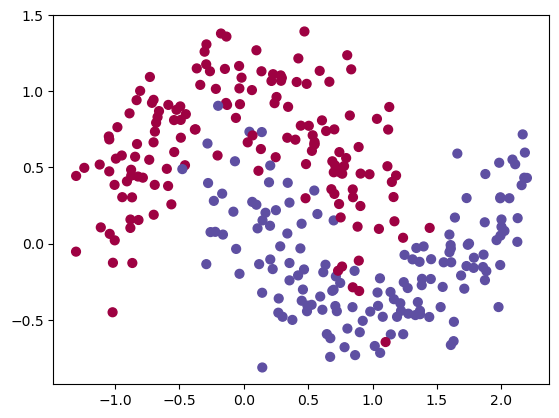

In [27]:
from opt_utils_v1a import load_dataset


train_X, train_Y = load_dataset()

In [28]:
train_X.shape, train_Y.shape

((2, 300), (1, 300))

In [29]:
class Custom_Dataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __len__(self):
        return self.y.shape[1]
    
    
    def __getitem__(self, index):
        return self.x[:, index], self.y[:, index]

In [30]:
data = Custom_Dataset(train_X, train_Y)

In [31]:
data_load = torch.utils.data.DataLoader(data, 32, shuffle=True, num_workers=8)

In [32]:
loss_f = torch.nn.BCELoss()
opti = torch.optim.SGD(model.parameters(), lr=0.0007)

2024-04-30 10:27:53.211178: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-30 10:27:53.319794: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-30 10:27:53.322553: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-04-30 10:27:53.322566: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [33]:
%%time


epochs = 4000

history = []

for epoch in range(1, epochs + 1):
    total_loss = 0
    for x, y in iter(data_load):
        pred = model(x.to(torch.float32))
        
        loss = loss_f(pred, y.to(torch.float32))
        
        opti.zero_grad()
        loss.backward()
        opti.step()
        
        total_loss += loss.item()
    
    total_loss /= len(data_load)
    history.append(total_loss)
    
    if epoch % 100 == 0:
        print(f"[epoch: {epoch}/{epochs}; loss: {total_loss}]")

[epoch: 100/4000; loss: 0.6871144652366639]
[epoch: 200/4000; loss: 0.6613786578178406]
[epoch: 300/4000; loss: 0.6365773141384125]
[epoch: 400/4000; loss: 0.6078090071678162]
[epoch: 500/4000; loss: 0.5856238663196563]
[epoch: 600/4000; loss: 0.5527445554733277]
[epoch: 700/4000; loss: 0.5236371487379075]
[epoch: 800/4000; loss: 0.5048096418380738]
[epoch: 900/4000; loss: 0.47270616292953493]
[epoch: 1000/4000; loss: 0.45413507521152496]
[epoch: 1100/4000; loss: 0.4339591026306152]
[epoch: 1200/4000; loss: 0.41761482059955596]
[epoch: 1300/4000; loss: 0.3976219162344933]
[epoch: 1400/4000; loss: 0.39774705469608307]
[epoch: 1500/4000; loss: 0.3913877338171005]
[epoch: 1600/4000; loss: 0.390251550078392]
[epoch: 1700/4000; loss: 0.37513656318187716]
[epoch: 1800/4000; loss: 0.3656011700630188]
[epoch: 1900/4000; loss: 0.3670066237449646]
[epoch: 2000/4000; loss: 0.35993691086769103]
[epoch: 2100/4000; loss: 0.3557377129793167]
[epoch: 2200/4000; loss: 0.3460035115480423]
[epoch: 2300/4

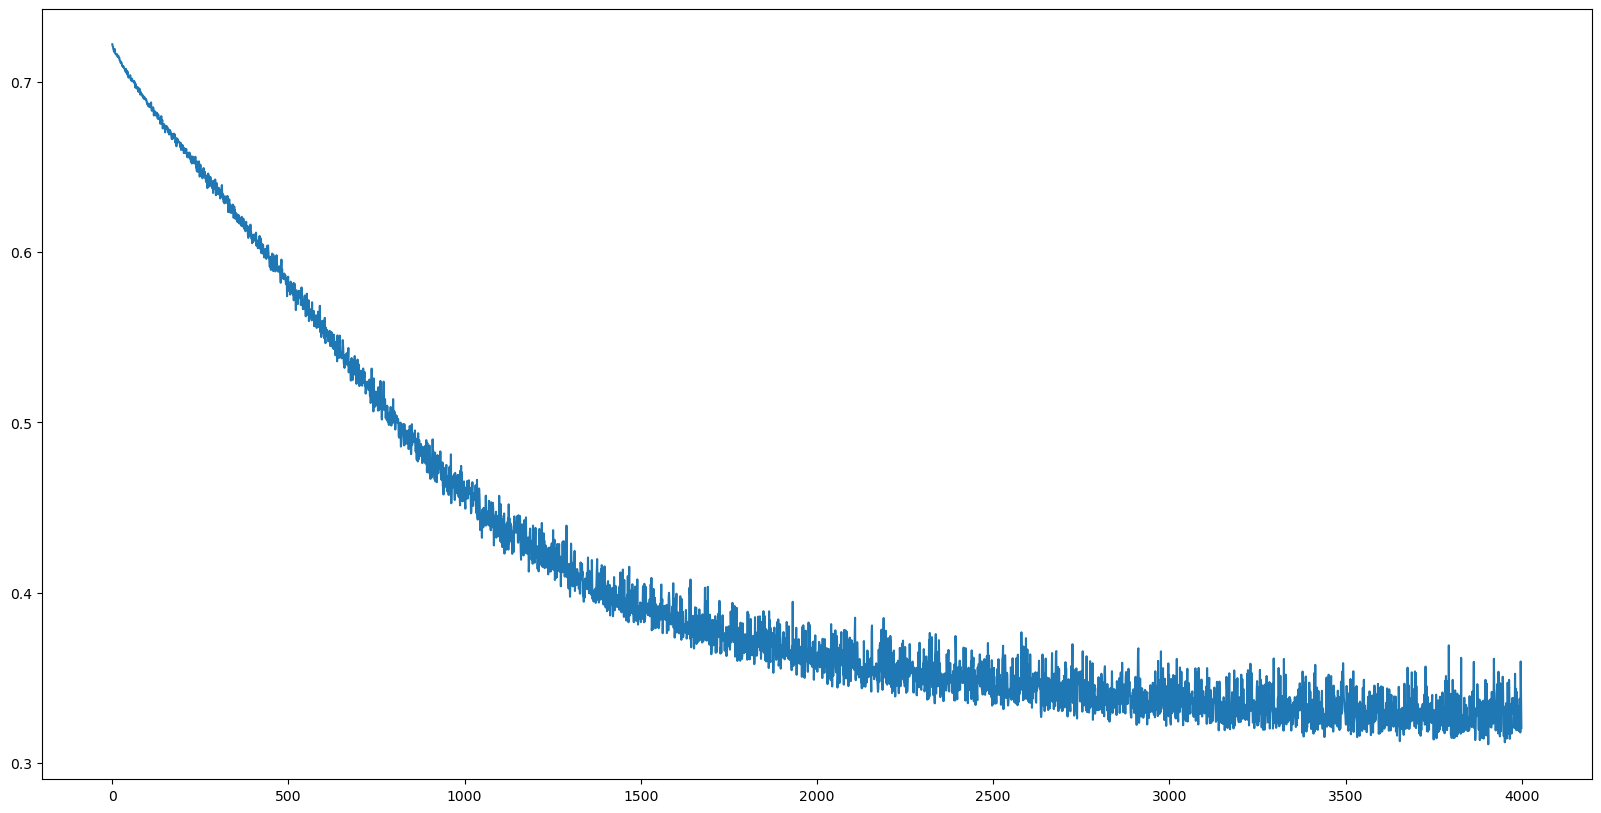

In [34]:
plt.figure(figsize=(20, 10))

plt.plot(history)
plt.show()

In [35]:
model = FC(3, 16)
opti = torch.optim.SGD(model.parameters(), lr=0.0007, momentum=0.9)

/home/user/anaconda3/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [36]:
%%time


epochs = 4000

history = []

for epoch in range(1, epochs + 1):
    total_loss = 0
    for x, y in iter(data_load):
        pred = model(x.to(torch.float32))
        
        loss = loss_f(pred, y.to(torch.float32))
        
        opti.zero_grad()
        loss.backward()
        opti.step()
        
        total_loss += loss.item()
    
    total_loss /= len(data_load)
    history.append(total_loss)
    
    if epoch % 100 == 0:
        print(f"[epoch: {epoch}/{epochs}; loss: {total_loss}]")

[epoch: 100/4000; loss: 0.35764471590518954]
[epoch: 200/4000; loss: 0.3343642264604568]
[epoch: 300/4000; loss: 0.31129131764173507]
[epoch: 400/4000; loss: 0.3096119910478592]
[epoch: 500/4000; loss: 0.29779139459133147]
[epoch: 600/4000; loss: 0.2754983603954315]
[epoch: 700/4000; loss: 0.28991038650274276]
[epoch: 800/4000; loss: 0.254012393951416]
[epoch: 900/4000; loss: 0.24306853115558624]
[epoch: 1000/4000; loss: 0.19836077615618705]
[epoch: 1100/4000; loss: 0.19812377616763116]
[epoch: 1200/4000; loss: 0.17578979805111886]
[epoch: 1300/4000; loss: 0.17638671919703483]
[epoch: 1400/4000; loss: 0.15274319127202035]
[epoch: 1500/4000; loss: 0.1617714386433363]
[epoch: 1600/4000; loss: 0.14608529768884182]
[epoch: 1700/4000; loss: 0.15301912724971772]
[epoch: 1800/4000; loss: 0.13241567499935628]
[epoch: 1900/4000; loss: 0.13041408974677324]
[epoch: 2000/4000; loss: 0.13007831908762454]
[epoch: 2100/4000; loss: 0.12831248082220553]
[epoch: 2200/4000; loss: 0.13436950147151946]
[ep

In [37]:
model = FC(3, 16)
opti = torch.optim.Adam(model.parameters(), lr=0.0007)

In [38]:
%%time


epochs = 4000

history = []

for epoch in range(1, epochs + 1):
    total_loss = 0
    for x, y in iter(data_load):
        pred = model(x.to(torch.float32))
        
        loss = loss_f(pred, y.to(torch.float32))
        
        opti.zero_grad()
        loss.backward()
        opti.step()
        
        total_loss += loss.item()
    
    total_loss /= len(data_load)
    history.append(total_loss)
    
    if epoch % 100 == 0:
        print(f"[epoch: {epoch}/{epochs}; loss: {total_loss}]")

[epoch: 100/4000; loss: 0.242803455889225]
[epoch: 200/4000; loss: 0.15957598239183426]
[epoch: 300/4000; loss: 0.13183954171836376]
[epoch: 400/4000; loss: 0.12767340652644635]
[epoch: 500/4000; loss: 0.12250783648341894]
[epoch: 600/4000; loss: 0.12892030850052832]
[epoch: 700/4000; loss: 0.12124663703143597]
[epoch: 800/4000; loss: 0.1388896569609642]
[epoch: 900/4000; loss: 0.1474532149732113]
[epoch: 1000/4000; loss: 0.12356756031513214]
[epoch: 1100/4000; loss: 0.1342352207750082]
[epoch: 1200/4000; loss: 0.11854785121977329]
[epoch: 1300/4000; loss: 0.11508331969380378]
[epoch: 1400/4000; loss: 0.14701332412660123]
[epoch: 1500/4000; loss: 0.13019657470285892]
[epoch: 1600/4000; loss: 0.1431066082790494]
[epoch: 1700/4000; loss: 0.12718005441129207]
[epoch: 1800/4000; loss: 0.13335839956998824]
[epoch: 1900/4000; loss: 0.11280804276466369]
[epoch: 2000/4000; loss: 0.12003644742071629]
[epoch: 2100/4000; loss: 0.1255269693210721]
[epoch: 2200/4000; loss: 0.11905718296766281]
[epo

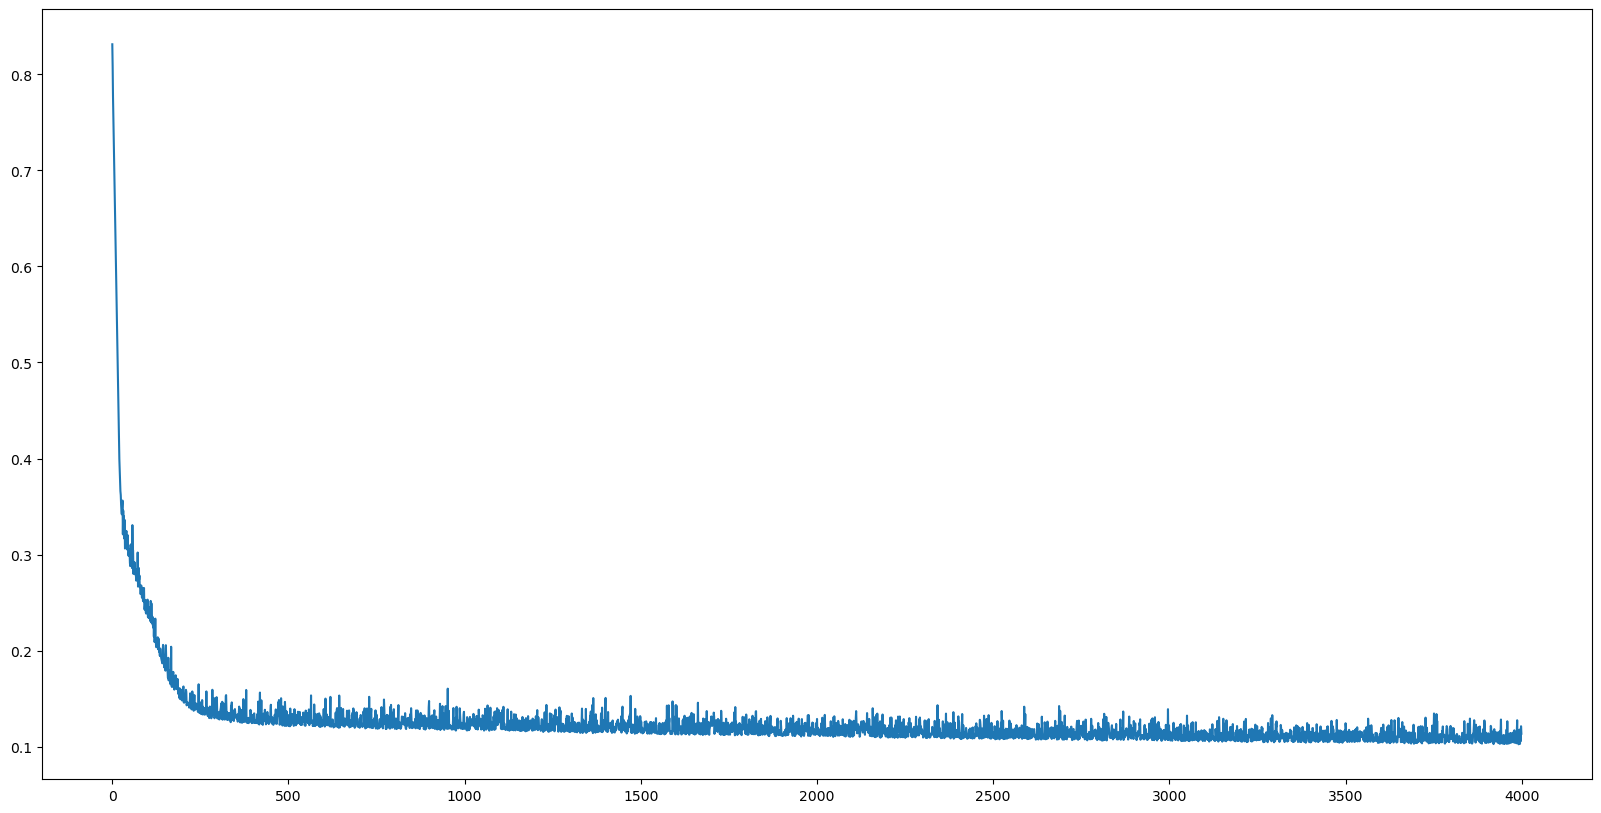

In [39]:
plt.figure(figsize=(20, 10))

plt.plot(history)
plt.show()